# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = './Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

In [2]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
%matplotlib inline

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [3]:
# Write your answer here

# Ebola Folder 
DATA_FOLDER_ebola = DATA_FOLDER + '/ebola'
# Directories in the folder
ebola_directories = os.listdir(DATA_FOLDER_ebola)
# Remove License File
del ebola_directories[ebola_directories.index('LICENSE')]

# Names of the columns which contain the total number of daily incidents
data_columns = {'liberia':['Date','Variable', 'National'],
                'sl': ['date','variable', 'National'],
                'guinea':['Date','Description', 'Totals']
               }

### Load All CSV Files Contained In One Folder
TODO : write the explanatory paragraph

In [4]:
# Loads the information relevant to deaths and cases within the csv files contained in the directory for a given country

def load_csv_files_into_dataframe(folder, country):
    country_folder = folder + '/'+ country +'_data'
    csv_files = os.listdir(country_folder)    
    
    all_data = pd.DataFrame()
    
    date = data_columns[country][0]
    description = data_columns[country][1]
    totals = data_columns[country][2]
    
    for i, file in enumerate(csv_files):
        
        daily_csv = pd.read_csv(country_folder + '/' +file)
        
        # Find columns containing death or case keywords
        motives  = daily_csv[description][daily_csv[description].str.contains("death|case|Death|Case")]
        # Create a dictionary with the date and country
        daily_dict = {'Date': file[:10], 'Country':country}
        # Add the motives with corresponding total / national values to the dictionary
        daily_dict.update(dict(zip(motives.tolist(), daily_csv[totals][motives.index].tolist())))
        # Append the dictionary to the dataframe
        all_data = all_data.append(daily_dict, ignore_index = True)
    all_data = all_data.apply(pd.to_numeric, errors = 'ignore')
    all_data.Date = pd.to_datetime(all_data.Date)
    all_data['Month']  = all_data.Date.dt.month
    all_data['Year']  = all_data.Date.dt.year
    #all_data.set_index(['Date','Country'], inplace = True)
    return all_data

### Liberia Dataset

In [126]:
liberia_data = load_csv_files_into_dataframe(DATA_FOLDER_ebola,'liberia')
liberia_data.reset_index(inplace = True)
liberia_data.dropna(thresh=2, axis = 1, inplace = True) #drops columns with just one value different from NaN

### Selecting the Most Relevant Columns For "Cases"

For Liberia, the columns used to compute the new cases will be:
    - New Case/s (Probable)
    - New Case/s (Suspected)
    - New Case/s (confirmed)
Our approach has been to sum all the data of these three columns and then compute the monthly average taking into account confirmed, probable and suspected cases. So we will give an upper limit for the average number of new cases. The lower limit would be given by only using the *"New case/s (confirmed)"* column.

We also added the column *"Total confirmed cases"* to show why we decided not to use this column for the computation (reasons will be given later).

In [127]:
df_data_1 = pd.DataFrame({'Date': liberia_data.Date,
                     'Total confirmed cases': liberia_data['Total confirmed cases'],
                     'New Case/s (Probable)': liberia_data['New Case/s (Probable)'],
                     'New Case/s (Suspected)': liberia_data['New Case/s (Suspected)'],
                     'New case/s (confirmed)': liberia_data['New case/s (confirmed)'],
                     'Month': liberia_data['Month']})

We decided that we couldn't use the data from December for various reasons:
- 1) We discovered (or at least it's our guess) that from day 2014-12-04 untill the end the data in the *"New Case/s"* rows starts to be cummulative, while it should be new daily data.
- 2) The December data from the *"New Case/s (Probable)"* and *"New Case/s (Suspected)"* is misleading. It is a cumulative type of data but we can clearly see that it decreases, which is not possible.
- 3) The data of December of *"New case/s (confirmed)"* should be placed in the column *"Total confirmed cases"*, but then we wouldn't have any data of December for the column *"New case/s (confirmed)"*.

For the calculation of the averaged new cases per month we used the 3 *"New Case/s"* columns. Taking into account this and the previous reasons, we decided not to make the analysis of December data. Basically, we lack data and the data little data we have is misleading for this month.

In the next cell we print the December data so that you can understand why we made that decision.

In [128]:
df_data_1.tail(10)

,Date,Month,New Case/s (Probable),New Case/s (Suspected),New case/s (confirmed),Total confirmed cases
90,2014-11-30,11,NaN,NaN,10.0,2823.0
91,2014-12-01,12,9.0,25.0,1.0,2823.0
92,2014-12-02,12,10.0,18.0,9.0,2824.0
93,2014-12-03,12,NaN,NaN,NaN,2830.0
94,2014-12-04,12,1800.0,3054.0,2867.0,NaN
95,2014-12-05,12,1808.0,3056.0,2867.0,NaN
96,2014-12-06,12,1810.0,3056.0,2869.0,NaN
97,2014-12-07,12,1829.0,3067.0,2869.0,NaN
98,2014-12-08,12,1805.0,3054.0,2927.0,NaN
99,2014-12-09,12,1801.0,3050.0,2946.0,NaN


In [129]:
# The data of December is dropped with a query.
df_data_1 = df_data_1.query('Month < 12')

As said, we add up the data of the 3 useful columns. We use the *.cumsum()* function to convert the daily new cases data into cumulative new cases data.

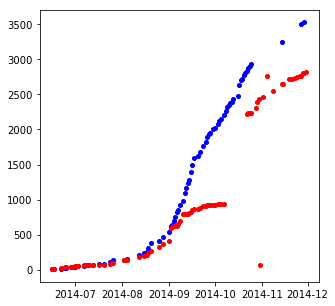

In [131]:
cum_data_new_cases = (df_data_1['New case/s (confirmed)'].cumsum() 
                      + df_data_1['New Case/s (Probable)'].cumsum()
                      + df_data_1['New Case/s (Suspected)'].cumsum())

plt.figure(figsize = (5,5))
plt.plot(df_data_1['Date'], cum_data_new_cases, 'bo', markersize = 4)
plt.plot(df_data_1['Date'], df_data_1['Total confirmed cases'], 'ro', markersize = 4)

As we see, the *"Total confirmed cases"* (red-dotted curve) data doesn't fit well the expected behaviour of the ebola virus. In addition, we are missing data from October and it would be extremely rough to interpolate. For these reasons we didn't use this column to compute the calculations.

In contrast, the cumulative data (blue-dotted curve) fits more the expected behaviour of the virus, as it doesn't have drastic changes of the curvature.

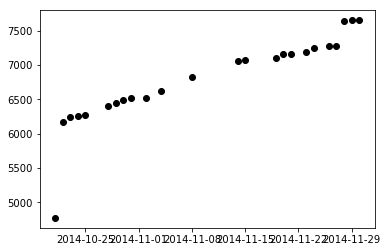

In [132]:
plt.plot(df_data_1['Date'], liberia_data['Cumulative confirmed, probable and suspected cases'][:91], 'ko')
#comment why we don't consider this data

### Selecting the Most Relevant Columns For "Deaths"

For the calculations we are going to use the following columns:
    - Total death/s in confirmed, probable, suspected cases
    - Total death/s in confirmed, \n probable, suspected cases
    
When combined, the other columns (from now on we will refer to them as verification columns) verify that the *"Total death/s in confirmed, probable, suspected cases"* column is coherent. They will not be used for the calculation.

In [133]:
df_data_2 = pd.DataFrame({'Date': liberia_data.Date,
                     'Total death/s in confirmed cases': liberia_data['Total death/s in confirmed cases'],
                     'Total death/s in probable cases': liberia_data['Total death/s in probable cases'],
                     'Total death/s in suspected cases': liberia_data['Total death/s in suspected cases'],
                     'Total death/s in confirmed, probable, suspected cases': liberia_data['Total death/s in confirmed, probable, suspected cases'],
                     'Total death/s in confirmed, \n probable, suspected cases': liberia_data['Total death/s in confirmed, \n probable, suspected cases'],
                     'Month': liberia_data['Month']})

#### Plotting verification columns

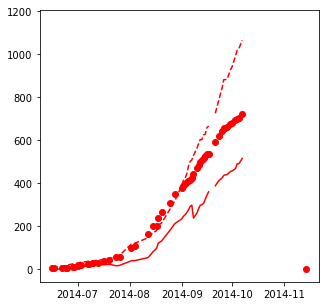

In [134]:
plt.figure(figsize = (5,5))
plt.plot(df_data_2['Date'], df_data_2['Total death/s in confirmed cases'], 'r--')
plt.plot(df_data_2['Date'], df_data_2['Total death/s in probable cases'], 'ro')
plt.plot(df_data_2['Date'], df_data_2['Total death/s in suspected cases'], 'r')

#### Modifying data to make it coherent
- need to shift the data of the continous red line after the drop (a total cannot decrease).
- need to clear the last data point of the red-dotted curve.

##### Continous red line correction

In [135]:
modified_column = df_data_2['Total death/s in suspected cases']
# Check where there is an drop (we get True values if there is a drop)
outlier = modified_column.diff()<0
# Get the index/s of the drops
outlier = outlier.index[outlier == True].tolist()
# We add the drop lenght to all the data that is after the drop
for outlier_index in outlier:
    correction = modified_column[outlier_index-1] - modified_column[outlier_index]
    modified_column.iloc[outlier_index:] = modified_column.iloc[outlier_index:] + correction
# Now the continous red line doesn't have any drops anymore

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### Deletion of the last data point in the red-dotted curve

In [136]:
#Spotting the index of the last data point
print(df_data_2['Total death/s in probable cases'].tail(25)) # it's the index 79
#Convert it to a NaN value
df_data_2['Total death/s in probable cases'].iloc[79] = np.nan

70    NaN
71    NaN
72    NaN
73    NaN
74    NaN
75    NaN
76    NaN
77    NaN
78    NaN
79    0.0
80    NaN
81    NaN
82    NaN
83    NaN
84    NaN
85    NaN
86    NaN
87    NaN
88    NaN
89    NaN
90    NaN
91    NaN
92    NaN
93    NaN
94    NaN
95    NaN
96    NaN
97    NaN
98    NaN
99    NaN
Name: Total death/s in probable cases, dtype: float64


C:\Anaconda\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### Plot of the veirfication columns (after cleaning)

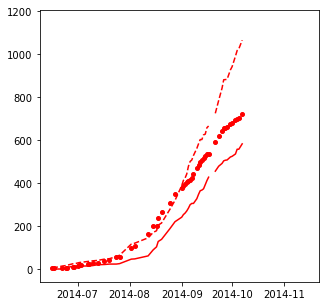

In [137]:
plt.figure(figsize = (5,5))
plt.plot(df_data_2['Date'], df_data_2['Total death/s in confirmed cases'], 'r--')
plt.plot(df_data_2['Date'], df_data_2['Total death/s in probable cases'], 'ro', markersize = 4)
plt.plot(df_data_2['Date'], df_data_2['Total death/s in suspected cases'], 'r')

#### Plot of all the data that we will use to compute the calculations + verification columns

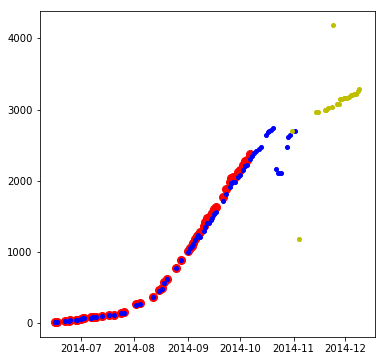

In [138]:
cum_data_deaths = (df_data_2['Total death/s in confirmed cases'] 
                   + df_data_2['Total death/s in probable cases'] 
                   + df_data_2['Total death/s in suspected cases'])

plt.figure(figsize = (6,6))
plt.plot(df_data_2['Date'], cum_data_deaths, 'ro', markersize = 8)
plt.plot(df_data_2['Date'], df_data_2['Total death/s in confirmed, probable, suspected cases'], 'bo', markersize = 4)
plt.plot(df_data_2['Date'], df_data_2['Total death/s in confirmed, \n probable, suspected cases'], 'yo', markersize = 4)

We can clearly see why now we used verification columns. We can see that the data from *"Total death/s in confirmed, probable, suspected cases"* (blue) is coherent with the verification columns (red).

As we can choose between the blue and red curves because they represent the same, we will be using the blue curve as it has slightly more data.
We can also observe that the data from the *"Total death/s in confirmed, \n probable, suspected cases"* column (yellow) completes the data that was missing for the last months of the blue and red curves.

As we see we need to clean the outliers of the dotted-yellow curve (second datapoint and datapoint on the top) and also remove the last data points of the blue-dotted curve because it's misleading (the total number of deaths can't decrease and then go up again).

#### Cleaning outliers

#### Top data point & Second data point (yellow-dotted curve)

In [139]:
# CLEANING THE TOP DATA POINT

modified_column = df_data_2['Total death/s in confirmed, \n probable, suspected cases']
# Boolean series from which we will take the index of the outlier
outlier = modified_column.diff()<0
# Shift values in order to get the correct index
outlier = outlier.shift(-1)
# Getting the index of the outlier
outlier = outlier.index[outlier == True].tolist()
# Replacing it with NaN value
modified_column.iloc[outlier] = np.nan

# CLEANING THE SECOND DATA POINT

# Getting the index of the outlier
outlier_index = modified_column.iloc[modified_column.first_valid_index()+1:].first_valid_index()
# Replacing it with Nan
modified_column.iloc[outlier_index] = np.nan

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### Clean last incoherent datapoints (blue-dotted line)

In [140]:
modified_column = df_data_2['Total death/s in confirmed, probable, suspected cases']
# Boolean series from which we will take the index of the outlier
bad_data = modified_column.diff()<0
# Get the index of the drop (we get a list because there are 2 drops, although we only see the big one in mid October)
outlier = bad_data[bad_data == True].index.tolist()
# Replace both outliers with NaN values
modified_column.iloc[outlier[0]] = np.nan
modified_column.iloc[outlier[1]-1:] = np.nan

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### Plot of all the data that we will use to compute the calculations + verification columns (after cleaning)

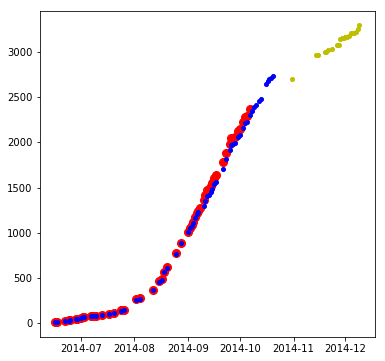

In [141]:
cum_data_deaths = (df_data_2['Total death/s in confirmed cases'] 
                   + df_data_2['Total death/s in probable cases'] 
                   + df_data_2['Total death/s in suspected cases'])

plt.figure(figsize = (6,6))
plt.plot(df_data_2['Date'], cum_data_deaths, 'ro', markersize = 8)
plt.plot(df_data_2['Date'], df_data_2['Total death/s in confirmed, probable, suspected cases'], 'bo', markersize = 4)
plt.plot(df_data_2['Date'], df_data_2['Total death/s in confirmed, \n probable, suspected cases'], 'yo', markersize = 4)

We see that the data has been cleaned. 

The final step will be to merge the blue line with the yellow line and create the final dataframe with the deaths and new cases data from Liberia.

### Final Liberia dataframe

In [142]:
# Merge the two columns
deaths = df_data_2['Total death/s in confirmed, probable, suspected cases'].add( \
                                df_data_2['Total death/s in confirmed, \n probable, suspected cases'], fill_value =  0.)
# Column for the new cases
new_cases = cum_data_new_cases

# Create the final Liberia df
df_liberia = pd.DataFrame({'Date': liberia_data.Date, 'Deaths': deaths, 'New_cases': new_cases})

### Guinea Dataset

In [551]:
guinea_data = load_csv_files_into_dataframe(DATA_FOLDER_ebola,'guinea')
guinea_data = guinea_data.apply(pd.to_numeric, errors='ignore')
guinea_data.reset_index(inplace = True)
guinea_data.dropna(thresh=2, axis = 1, inplace = True)

guinea_data

,Date,Country,New cases of confirmed,New cases of probables,New cases of suspects,Total cases of confirmed,Total cases of probables,Total cases of suspects,Total deaths (confirmed + probables + suspects),Total deaths of confirmed,...,Total deaths of suspects,Total new cases registered so far,New cases of confirmed among health workers,New deaths registered,New deaths registered among health workers,Total case of confirmed among health workers,Total deaths registered among health workers,Total number of hospitalized cases in CTE,Total suspected non-class cases,Month
0,2014-08-04,guinea,4.0,0.0,5.0,351.0,133.0,11.0,363.0,228.0,...,2.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
1,2014-08-26,guinea,10.0,NaN,18.0,490.0,141.0,30.0,958.0,292.0,...,2.0,28.0,0.0,5.0,0.0,45.0,26.0,87.0,518.0,8
2,2014-08-27,guinea,10.0,0.0,12.0,499.0,142.0,22.0,438.0,294.0,...,2.0,22.0,0.0,2.0,0.0,45.0,26.0,80.0,518.0,8
3,2014-08-30,guinea,9.0,0.0,15.0,533.0,142.0,32.0,468.0,324.0,...,2.0,24.0,0.0,5.0,0.0,50.0,26.0,82.0,560.0,8
4,2014-08-31,guinea,29.0,8.0,9.0,563.0,150.0,36.0,489.0,337.0,...,2.0,46.0,0.0,3.0,0.0,50.0,26.0,99.0,642.0,8
5,2014-09-02,guinea,14.0,0.0,11.0,591.0,150.0,49.0,501.0,349.0,...,2.0,25.0,0.0,5.0,0.0,50.0,26.0,105.0,642.0,9
6,2014-09-04,guinea,17.0,0.0,13.0,621.0,151.0,51.0,522.0,368.0,...,3.0,30.0,0.0,5.0,0.0,50.0,26.0,103.0,682.0,9
7,2014-09-07,guinea,11.0,0.0,5.0,678.0,151.0,32.0,557.0,402.0,...,4.0,16.0,2.0,4.0,0.0,54.0,28.0,102.0,714.0,9
8,2014-09-08,guinea,11.0,0.0,5.0,678.0,151.0,32.0,557.0,402.0,...,4.0,16.0,2.0,4.0,0.0,54.0,28.0,102.0,714.0,9
9,2014-09-09,guinea,7.0,0.0,9.0,683.0,151.0,33.0,565.0,410.0,...,4.0,16.0,0.0,7.0,0.0,54.0,28.0,92.0,747.0,9


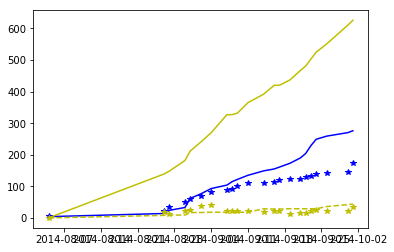

In [187]:
plt.plot(np.array(guinea_data['Date']), np.array(guinea_data['New cases of confirmed']).cumsum(), 'b') 
plt.plot(np.array(guinea_data['Date']), np.array(guinea_data['New cases of probables']).cumsum(), 'b--') 
plt.plot(np.array(guinea_data['Date']), np.array(guinea_data['New cases of suspects']).cumsum(), 'b*') 



plt.plot(np.array(guinea_data['Date']), np.array(guinea_data['Total cases of confirmed'])-guinea_data['Total cases of confirmed'][0], 'y') 
plt.plot(np.array(guinea_data['Date']), np.array(guinea_data['Total cases of probables'])-guinea_data['Total cases of probables'][0], 'y--') 
plt.plot(np.array(guinea_data['Date']), np.array(guinea_data['Total cases of suspects'])-guinea_data['Total cases of suspects'][0], 'y*') 

# plt.plot(np.array(guinea_data['Date']), np.array(guinea_data['Total new cases registered so far']), 'r') 

In [118]:
#plt.plot(np.array(guinea_data['Date']), np.array(guinea_data['Total deaths of confirmed']), 'y*') 
#plt.plot(np.array(guinea_data['Date']), np.array(guinea_data['Total deaths of probables']), 'y+') 
#plt.plot(np.array(guinea_data['Date']), np.array(guinea_data['Total deaths of suspects']), 'y--') 

cum_all_secondpart = guinea_data['Total deaths of confirmed'] + guinea_data['Total deaths of probables'] + guinea_data['Total deaths of suspects']
plt.plot(np.array(guinea_data['Date'])[:19], np.array(cum_all_secondpart)[:19], 'r') # from day 20 all are outliers
plt.plot(np.array(guinea_data['Date']), np.array(guinea_data['Total deaths (confirmed + probables + suspects)']), 'bo') 

NameError: name 'guinea_data' is not defined

### Sierra Leone Dataset

In [189]:
sl_data = load_csv_files_into_dataframe(DATA_FOLDER_ebola,'sl')
sl_data = sl_data.apply(pd.to_numeric, errors='ignore')
sl_data.reset_index(inplace = True)

sl_data.cum_noncase = sl_data.cum_noncase.astype(str)
sl_data.cum_noncase = sl_data.cum_noncase.apply(str.replace, args = (',', ''))
sl_data.cum_noncase = sl_data.cum_noncase.astype(float)
sl_data.new_noncase = sl_data.new_noncase.astype(float)

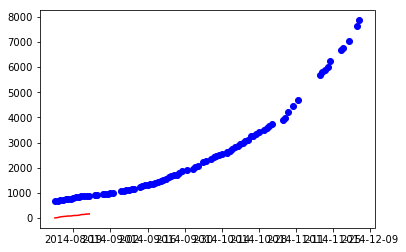

In [190]:
plt.plot(np.array(sl_data['Date']), np.array(sl_data['cum_noncase']), 'bo') 
plt.plot(np.array(sl_data['Date']), np.array(sl_data['new_noncase']).cumsum(), 'r') 

In [191]:
#plt.plot(np.array(sl_data['Date']), np.array(sl_data['etc_cum_deaths']), 'bo') 
plt.plot(np.array(sl_data['Date']), np.array(sl_data['etc_new_deaths']).cumsum(), 'ro') 

ValueError: ordinal must be >= 1

# TODO :  
- Format the dates to be the same for all the datasets
- Decide on what is a case and a death for each country -> add new columns to the existing df
- Merge the new columns of the 3 countries with the indexes to create the final df 

daily average per month of new cases and deaths

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [21]:
# Write your answer here
DATA_FOLDER_microbiome = DATA_FOLDER + '/microbiome'

# Get all the files in the folder
microbiome_cvs_files = os.listdir(DATA_FOLDER_microbiome)
# Get the 9 first spreadsheets
RNA_seq_files = [x for x in microbiome_cvs_files if 'MID' in x]
# Get the last spreadsheet
metadata_file = [x for x in microbiome_cvs_files if x not in RNA_seq_files]

# Load the metadata into a dataframe
metadata_df = pd.read_excel((DATA_FOLDER_microbiome + '/' + metadata_file[0]))
metadata_columns = metadata_df.columns.values

# Create the dataframe
microbiome_data = pd.DataFrame(index = [])

# Load the 9 spreadsheets into one dataframe
for file in RNA_seq_files:
    # Load the xls file
    df = pd.read_excel(DATA_FOLDER_microbiome + '/' +file,header= None)
    # Get the name of the barcode for the given file
    Barcode_idx = file.replace('.xls','')
    # Get the metadata associated to the given barcode
    file_metadata = metadata_df[metadata_df['BARCODE'].str.contains(Barcode_idx)].values[0]
    
    # Save the metadata to the dataframe
    for c, col in enumerate(metadata_columns):
        df[col] = file_metadata[c]

    # Merge it with the whole dataframe
    microbiome_data = pd.concat([microbiome_data,df])

# Rename the columns and set the Name column as index 
microbiome_data.rename(columns={0:'NAME', 1:'NUMBER'}, inplace=True)
microbiome_data = microbiome_data.set_index(['NAME', 'BARCODE']) # TODO : check if it worked
print("Index is unique : " + str(microbiome_data.index.is_unique))

# Replace all nan values with unknown
microbiome_data = microbiome_data.replace(np.nan, 'unknown', regex=True)

microbiome_data.head()

Index is unique : True


,,NUMBER,GROUP,SAMPLE
NAME,BARCODE,,,
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",MID1,7,EXTRACTION CONTROL,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus",MID1,2,EXTRACTION CONTROL,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Sulfolobales Sulfolobaceae Stygiolobus",MID1,3,EXTRACTION CONTROL,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Thermoproteales Thermofilaceae Thermofilum",MID1,3,EXTRACTION CONTROL,unknown
"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Methanocellales Methanocellaceae Methanocella",MID1,7,EXTRACTION CONTROL,unknown


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [22]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')
print(' ')

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

### Importing Seaborn for Color Palettes

In [23]:
import seaborn as sns

# set the default color palette
# try other options: 'Blues', sns.cubehelix_palette(8)
sns.set_palette('Blues')

# Seaborn can also use a context for different purpose
# possible values are paper, notebook, talk, and poster
sns.set_context("notebook")

### Loading the Dataset

In [24]:
titanic_data = pd.read_excel(DATA_FOLDER+'/titanic.xls')
### ticket column has values like:   PC 1234        and values like:  1456
### This code tries to create a new column, splitting values like PC 1234 and keeping just 1234, while keeping values like 1456 
### untouched
### It's not finished, so do not consider it yet

#titanic_data[titanic_data.ticket == 'LINE'] = np.nan
'''
vector = []
j = 0
for i in titanic_data['ticket']:
    try:
        i = int(i)
        vector.append(i)
        j += 1
    except:
        try:
            print(i.split()[1])
            j += 1
        except:
            print('!!!!!!', i)
            print('J val aquest valor', j)
            j += 1
'''

"\nvector = []\nj = 0\nfor i in titanic_data['ticket']:\n    try:\n        i = int(i)\n        vector.append(i)\n        j += 1\n    except:\n        try:\n            print(i.split()[1])\n            j += 1\n        except:\n            print('!!!!!!', i)\n            print('J val aquest valor', j)\n            j += 1\n"

### 3.1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 

TODO : pas compris ce qu'ils entendent par range ni "Indicate and transform the attributes that can be `Categorical`."

Issue with the inf and converting to int

In [25]:
# Transform age to float
titanic_data = pd.read_excel(DATA_FOLDER + '/titanic.xls')
titanic_data.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [26]:
def get_attributes_description(df):
    # Get attribute description
    dicts = []
    dicts.append(df.dtypes.to_dict())
    dicts.append(df.min(skipna = True).to_dict())
    dicts.append(df.max(skipna = True).to_dict())

    attributes = {k:[d[k] for d in dicts] for k in dicts[0] }

    description = pd.DataFrame.from_dict(attributes, orient = 'index')
    description.rename(columns={0:'Type', 1:'Minimum', 2:'Maximum'}, inplace=True)
    return description

titanic_description = get_attributes_description(titanic_data)
print(titanic_description)

KeyError: 'ticket'

The attributes which can be defined as categorical are those which have predefined levels such as pclass (3), sex (2), cabin (187), embarked (3) and boat (28).

In [ ]:
categorical_attributes = ['pclass', 'sex', 'cabin', 'embarked', 'boat']

categ_titanic = titanic_data.copy()
#categ_titanic = categ_titanic.replace('inf', None, regex=True) # TODO : check if okay... 
#categ_titanic = categ_titanic.replace(np.nan, 'unknown', regex=True) # TODO : check if okay... 

for attribute in categorical_attributes:
    attribute_cat = categ_titanic[attribute].unique().tolist() 
    
    try : 
        categ_titanic[attribute] = categ_titanic[attribute].astype('category')
        categ_titanic[attribute].cat.categories = attribute_cat 
    except : 
        attribute_cat = map(lambda x:x if (x is not np.nan) else 'unknown',attribute_cat)
        categ_titanic[attribute] = categ_titanic[attribute].replace(np.nan, 'unknown', regex=True)
        categ_titanic[attribute] = categ_titanic[attribute].astype('category')
        categ_titanic[attribute].cat.categories = attribute_cat 

categ_titanic_description = get_attributes_description(categ_titanic)
print(categ_titanic_description)

### 3.2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 

TRAVEL CLASS???

In [29]:
import matplotlib.pyplot as plt
titanic_data = pd.read_excel(DATA_FOLDER + '/titanic.xls')
modified_titanic_data = titanic_data.copy(deep = True)

## The cell below only works if it has never been executed.
If you already executed it, go run again the cell where you read the titanic file.

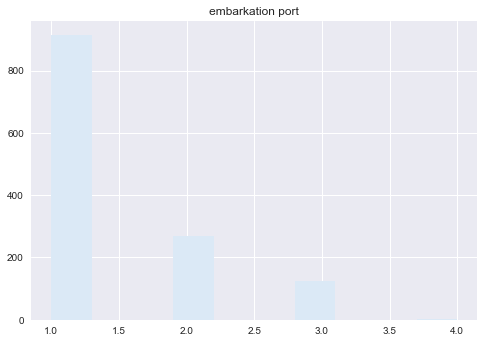

In [30]:
modified_titanic_data.set_value(168, 'embarked', 'unknown')
modified_titanic_data.set_value(284, 'embarked', 'unknown')

modified_titanic_data.embarked.replace({'S': 1, 'C': 2, 'Q': 3, 'unknown': 4}, inplace = True)
#titanic_data.embarked.map(relationships, inplace = True)
modified_titanic_data.embarked.hist()
plt.title('embarkation port')

In [31]:
modified_titanic_data.sex.replace({'female': 1, 'male': 2}, inplace = True)

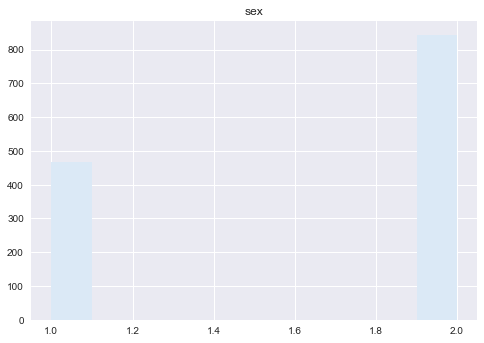

In [32]:
modified_titanic_data['sex'].hist()
plt.title('sex')

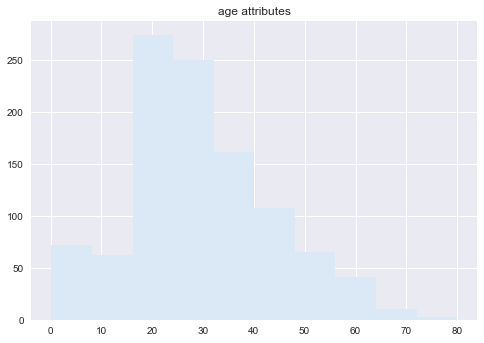

In [33]:
modified_titanic_data.age.hist(bins = 10)
plt.title('age attributes')

## All 4 plots together

AttributeError: Unknown property column

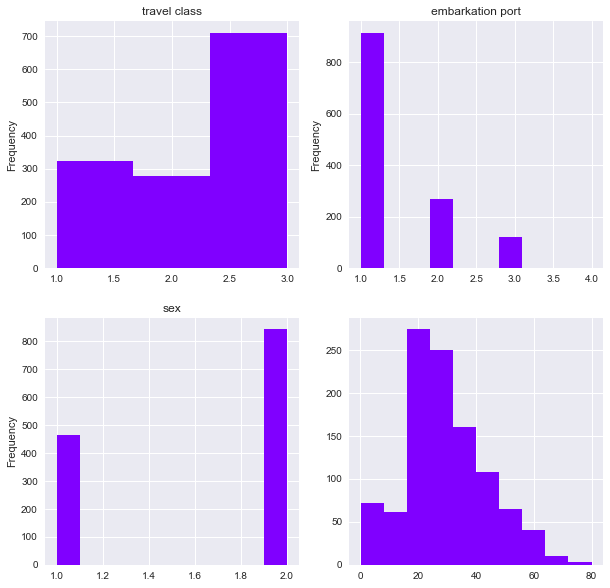

In [35]:
plt.figure(figsize = (10, 10))
plt.subplot(221)
titanic_data.pclass.plot(kind='hist', bins = 3, colormap = 'rainbow')
plt.title('travel class')
plt.subplot(222)
modified_titanic_data.embarked.plot(kind='hist', colormap = 'rainbow')
plt.title('embarkation port')
plt.subplot(223)
modified_titanic_data['sex'].plot(kind='hist', colormap = 'rainbow')
plt.title('sex')
plt.subplot(224)
modified_titanic_data.age.plot(kind='hist', colormap = 'rainbow')
plt.title('age attributes')

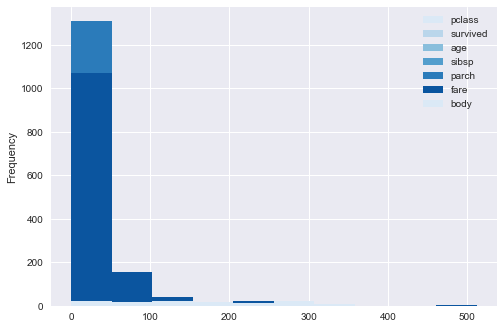

In [42]:
titanic_data[['pclass', 'embarked', 'sex', 'age']].apply(pd.value_counts).plot(kind='hist', subplots = True)

C:\Anaconda\lib\site-packages\pandas\core\indexes\api.py:77: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)
C:\Anaconda\lib\site-packages\pandas\core\frame.py:5637: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  index = _union_indexes(indexes)


AttributeError: 'function' object has no attribute 'plot'

TypeError: '<' not supported between instances of 'str' and 'float'

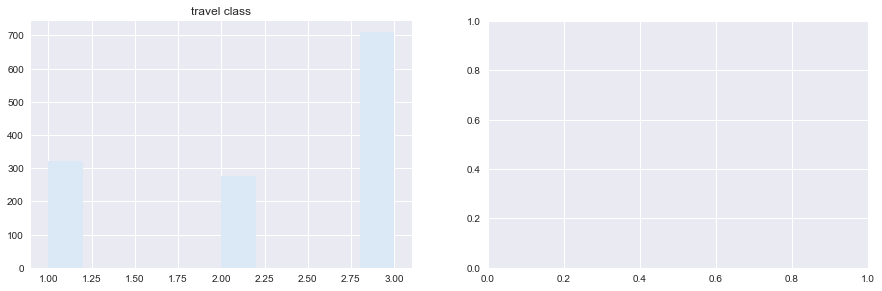

In [104]:
plt.figure(figsize = (15,10))
plt.subplot(221)
categ_titanic['pclass'].hist()
plt.title('travel class')
plt.subplot(222)
categ_titanic['embarked'].hist()
plt.title('embarkation port')
plt.subplot(223)
categ_titanic['sex'].hist()
plt.title('sex')
plt.subplot(221)
categ_titanic['age'].hist(bins = 10)
plt.title('age attributes')
plt.show()

### 3.3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.

F    0.790680
C    0.071047
B    0.046600
D    0.037433
E    0.034377
A    0.017571
u    0.000764
G    0.000764
T    0.000764
Name: cabin, dtype: float64


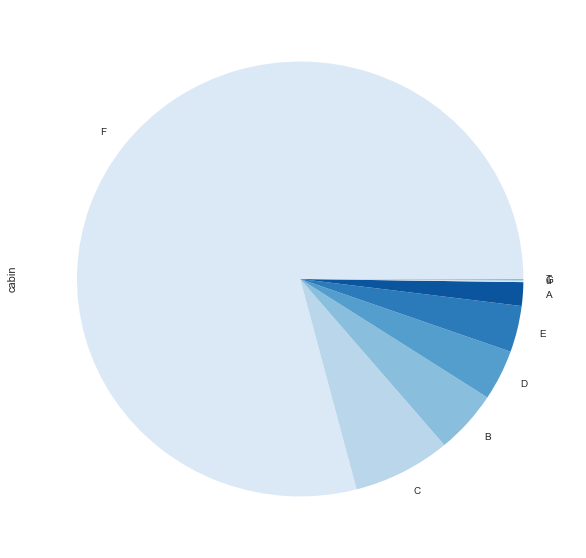

In [36]:
# Extract the cabin floors from the first letter of the cabins
cabin_floors = categ_titanic.cabin.str[0]
# Compute the total number of passengers
num_passengers = len(cabin_floors.tolist())
# Get the number of passengers per floor and compute the proportions
cabin_floors_proportions = cabin_floors.value_counts()/num_passengers
print(cabin_floors_proportions)

plt.figure(figsize = (10,10))
cabin_floors_proportions.plot.pie()

### 3.4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.

TODO : Pie chart?? based on the percentages or on the total number? Proportion = survived in class 1 / all passengers or all in class 1

In [69]:
def compute_survival_proportions(df, by_category):
    # Groupe the passengers by travel class
    travel_classes = df.groupby(by_category)
    # Get the average of passengers that survived for each class
    survival_per_class = travel_classes[['survived']].mean()
    print(survival_per_class)
    return survival_per_class

        survived
pclass          
1       0.619195
2       0.429603
3       0.255289


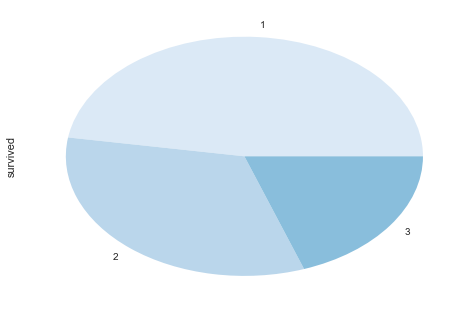

In [70]:
survival_class = compute_survival_proportions(categ_titanic, ['pclass'])
survival_class['survived'].plot.pie()

### 3.5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.

               survived
pclass sex             
1      female  0.965278
       male    0.340782
2      female  0.886792
       male    0.146199
3      female  0.490741
       male    0.152130


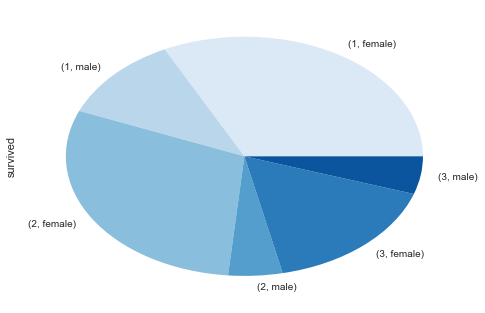

In [68]:
survival_class_sex = compute_survival_proportions(categ_titanic, ['pclass', 'sex'])
survival_class_sex['survived'].plot.pie()

### 3.6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [89]:
# Compute the median
median_age = categ_titanic['age'].median(skipna = True)
print((categ_titanic['age'] == median_age).sum()) 

32


There are too many people with the median age. It is not possible to cut based on the median and obtain equal sized categories. 

                         survived
age_categ pclass sex             
old       1      female  0.963964
                 male    0.333333
          2      female  0.871429
                 male    0.080645
          3      female  0.467532
                 male    0.157407
young     1      female  0.954545
                 male    0.538462
          2      female  0.939394
                 male    0.382353
          3      female  0.480000
                 male    0.187970


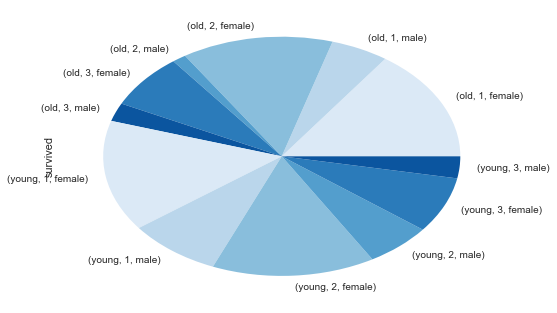

In [95]:
# Sort by age
age_sorted = categ_titanic.sort_values(['age'])
# Keep rows where age is not nan
age_sorted = age_sorted[np.isfinite(age_sorted['age'])]
# Get the number of passengers for which the age is given
num_passengers = len(age_sorted['age'].tolist())
# Break up the dataframe into two equal proportions by age category : young and old
age_sorted.loc[:(num_passengers//2),'age_categ']= 'young'
age_sorted.loc[(num_passengers//2):,'age_categ']= 'old'
#----------------------------------------------------------------------------------------------------

# Plot the survival proportions
survival_age_class_sex = compute_survival_proportions(age_sorted, ['age_categ','pclass', 'sex'])
survival_age_class_sex['survived'].plot.pie()